In [6]:
import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
#     m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, age, fc]])
print(np.mean(age))

[(3849, 5, 264), (3849, 5, 264), (3849,), (3849, 34716)]
14.398285268901013


In [7]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc - aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(3849, 5, 34716)
(3849, 34716)
(3849, 34716)


In [8]:
res5 = res
aps5 = aps

In [34]:
# Try partial correlation

from nilearn.connectome import ConnectivityMeasure

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

rest_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
nback_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))
emoid_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_emoid_good_filt.pkl', 'rb'))

pc = []
con = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)

for i,subtask in enumerate(basis):
    m = re.search('([^-]+)-(.*)', subtask)
    sub = m.group(1)
    task = m.group(2)
    if task == 'rest':
        ts = rest_ts
    elif task == 'nback':
        ts = nback_ts
    elif task == 'emoid':
        ts = emoid_ts
    p = con.fit_transform([ts[sub].T])
    pc.append(p)
    if i%100 == 0:
        print(f'Finished {i}')
    
pc = cat(pc)
print(pc.shape)

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished 700
Finished 800
Finished 900
Finished 1000
Finished 1100
Finished 1200
Finished 1300
Finished 1400
Finished 1500
Finished 1600
Finished 1700
Finished 1800
Finished 1900
Finished 2000
Finished 2100
Finished 2200
Finished 2300
Finished 2400
Finished 2500
Finished 2600
Finished 2700
Finished 2800
Finished 2900
Finished 3000
Finished 3100
Finished 3200
Finished 3300
Finished 3400
Finished 3500
Finished 3600
Finished 3700
Finished 3800
(3849, 34716)


In [165]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100).fit(fc)
fc_comp = pca.transform(fc)
fc_low = pca.inverse_transform(fc_comp)

print(fc_low.shape)

(1244, 34716)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

rmsefc = []
rmseens = []

for i in range(20):
    idcs = np.random.permutation(fc.shape[0])
    x0 = aps5#[idcs[:1244]]
    x1 = res1#[idcs[:1244]]
    x2 = fc#[idcs[:1244]]
    x = cat([x0, x1, x2], axis=1)
    y = age#[idcs[:1244]]

    xtr, xt, ytr, yt = train_test_split(x, y, train_size=0.05)

    mu = np.mean(ytr)
    ytr -= mu
    yt -= mu

    n = 34716

    xlst = [(xtr[:,a*n:(a+1)*n], xt[:,a*n:(a+1)*n]) for a in range(0,3)]
    xtr0, xt0, xtr1, xt1, xtr2, xt2 = [a for b in xlst for a in b]

    reg = Ridge(alpha=1).fit(xtr0, ytr)
    yhat0 = reg.predict(xt0)
    print(rmse(yhat0, yt))

    reg = Ridge(alpha=1).fit(xtr1, ytr)
    yhat1 = reg.predict(xt1)
    print(rmse(yhat1, yt))

    reg = Ridge(alpha=1).fit(xtr2, ytr)
    yhat2 = reg.predict(xt2)
    print(rmse(yhat2, yt))

    yhat = (yhat0+yhat1)/2
    print(rmse(yhat, yt))
    print(rmse(0, yt))
    print(f'{i} ----')
    
    rmsefc.append(rmse(yhat2, yt))
    rmseens.append(rmse(yhat, yt))
    
print(np.mean(rmsefc))
print(np.mean(rmseens))

3.1233248162798506
3.097381483507909
3.0771439069781024
3.0487042751867404
3.4672478932871083
0 ----
3.1594918429791052
3.1700638301385533
3.1246785407302147
3.111825636915654
3.470148717833023
1 ----
3.168444771624748
3.196717615746407
3.141824871484134
3.128233984807675
3.464751496085975
2 ----


KeyboardInterrupt: 

NameError: name 'remap' is not defined

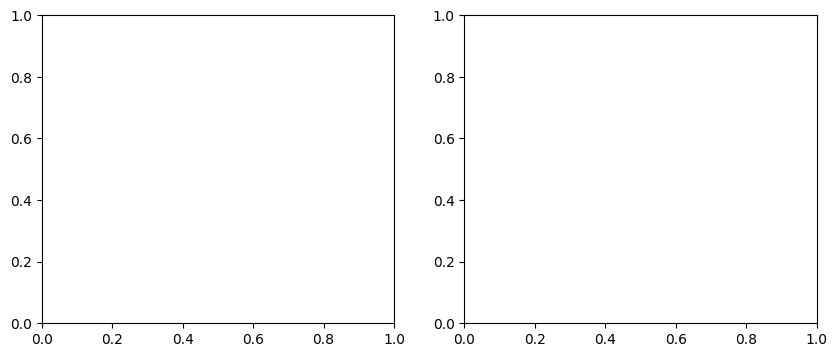

In [61]:
import matplotlib.pyplot as plt

num = 200

fig, ax = plt.subplots(1,2,figsize=(10,4))
# im0 = ax[0].imshow(remap(vec2mat(reg.coef_)))
im0 = ax[0].imshow(remap(vec2mat(reg.coef_*np.mean(aps, axis=0))))
im1 = ax[1].imshow(remap(vec2mat(aps[num])))
fig.colorbar(im0)
fig.colorbar(im1)
fig.show()

In [42]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
